# Time Series Forecast Projects

## 5-Step Forecasting Task
The 5 basic steps in a forecasting task are summarized by Hyndman and Athana­sopou­los in their book Forecasting: principles and practice. These steps are:

1. **Problem Definition.** The careful consideration of who requires the forecast and how the forecast will be used. 
This is described as the most difficult part of the process, most likely because it is entirely problem specific and subjective.
2. **Gathering Information.** The collection of historical data to analyze and model. This also includes getting access to domain experts and gathering information that can help to best interpret the historical information, and ultimately the forecasts that will be made.
3. **Preliminary Exploratory Analysis.** The use of simple tools, like graphing and summary statistics, to better understand the data. Review plots and summarize and note obvious temporal structures, like trends seasonality, anomalies like missing data, corruption, and outliers, and any other structures that may impact forecasting.
4. **Choosing and Fitting Models.** Evaluate two, three, or a suite of models of varying types on the problem. Models may be chosen for evaluation based on the assumptions they make and whether the dataset conforms. Models are configured and fit to the historical data.
5. **Using and Evaluating a Forecasting Model.** The model is used to make forecasts and the performance of those forecasts is evaluated and skill of the models estimated. This may involve back-testing with historical data or waiting for new observations to become available for comparison.

![](./data/5_setp.png)

## Iterative Forecast Development Process
The authors Shmueli and Lichtendahl in their book Practical Time Series Forecasting with R: A Hands-On Guide suggest an 8-step process.

This process extends beyond the development of a model and making forecasts and involves iterative loops.

Their process can be summarized as follows:

- Define Goal.
- Get Data.
- Explore and Visualize Series.
- Pre-Process Data.
- Partition Series.
- Apply Forecasting Method/s.
- Evaluate and Compare Performance.
- Implement Forecasts/Systems.

Below are the iterative loops within the process:

- Explore and Visualize Series => Get Data. Data exploration can lead to questions that require access to new data.
- Evaluate and Compare Performance => Apply Forecasting Method/s. The evaluation of models may raise questions or ideas for new methods or new method configurations to try.

The process is more focused on the ongoing development and refinement of one or more models on the problem until an acceptable level of performance is achieved.

![](./data/Iterative_Forecast_Development_Process.png)

## Suggestions and Tips
This section lists 10 suggestions and tips to consider when working through your time series forecasting project.

The thrust of these suggestions is centered on the premise that you cannot know what will work, let alone which methods will work well on your problem beforehand. And that the best source of knowledge on a forecasting project comes from the results of trial and error with real historical data.

1. Select or devise a time series forecast process that is tailored to your project, tools, team, and level of expertise.
2. Write down all assumptions and questions you have during analysis and forecasting work, then revisit them later and seek to answer them with small experiments on historical data.
3. Review a large number of plots of your data at different time scales, zooms, and transforms of observations in an effort to help make exploitable structures present in the data obvious to you.
4. Develop a robust test harness for evaluating models using a meaningful performance measure and a reliable test strategy, such as walk-forward validation (rolling forecast).
5. Start with simple naive forecast models to provide a baseline of performance for more sophisticated methods to improve upon.
6. Create a large number of perspectives or views on your time series data, including a suite of automated transforms, and evaluate each with one or a suite of models in order to help automatically discover non-intuitive representations and model combinations that result in good predictions for your problem.
7. Try a suite of models of differing types on your problem, from simple to more advanced approaches.
8. Try a suite of configurations for a given problem, including configurations that have worked well on other problems.
9. Try automated hyperparameter optimization methods for models to flush out a suite of well-performing models as well as non-intuitive model configurations that you would not have tried manually.
10.  Devise automated tests of performance and skill for ongoing predictions to help to automatically determine if and when a model has become stale and requires review or retraining.

# Project: Annual Water Usage in Baltimore

## Overview
In this tutorial, we will work through a time series forecasting project from end-to-end, from downloading the dataset and defining the problem to training a final model and making predictions. This project is not exhaustive, but shows how you can get good results quickly by working through a time series forecasting problem systematically. The steps of this project that we will work through are as follows:
1. Problem Description. 
2. Test Harness.
3. Persistence.
4. Data Analysis.
5. ARIMA Models.
6. Model Validation.

In [35]:
# check the versions of key python libraries
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

scipy: 1.9.1
numpy: 1.21.6
matplotlib: 3.5.2
pandas: 1.4.2
statsmodels: 0.13.2
sklearn: 1.0.2


In [1]:
# split into a training and validation dataset
from pandas import read_csv
series = read_csv('./water/water.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('./water/dataset.csv', header=False)
validation.to_csv('./water/validation.csv', header=False)
dataset.head(5)

Dataset 67, Validation 12


/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_13211/2974815352.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./water/water.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


Year
1885-01-01    356
1886-01-01    386
1887-01-01    397
1888-01-01    397
1889-01-01    413
Name: Water, dtype: int64

## Problem Description

The problem is to predict annual water usage.

The dataset provides the annual water usage in Baltimore from 1885 to 1963, or 79 years of data.

The values are in the units of liters per capita per day, and there are 79 observations.

The dataset is credited to Hipel and McLeod, 1994.

## Model Evaluation
Model evaluation will only be performed on the data in dataset.csv prepared in the previous section.

Model evaluation involves two elements:

- Performance Measure.
- Test Strategy.

## Test Strategy
Candidate models will be evaluated using walk-forward validation. This is because a rolling- forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data. The walk-forward validation will work as follows:
1. The first 50% of the dataset will be held back to train the model.
2. The remaining 50% of the dataset will be iterated and test the model. 
3. For each step in the test dataset:
- (a) A model will be trained.
- (b) A one-step prediction made and the prediction stored for later evaluation.
- (c) The actual observation from the test dataset will be added to the training dataset for the next iteration.
4. The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported.

In [2]:

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

## Persistence
The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. 

This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared. 

**The baseline prediction for time series forecasting is called the naive forecast, or persistence.** 

This is where the observation from the previous time step is used as the prediction for the observation at the next time step. 


In [7]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('./water/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=526.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=522.000
>Predicted=522.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=450.000
>Predicted=450.000, Expected=432.000
>Predicted=432.000, Expected=432.000
>Predicted=432.000, Expected=458.000
>Predicted=458.000, Expected=462.000
>Predicted=462.000, Expected=503.000
>Predicted=503.000, Expected=488.000
>Predicted=488.000, Expected=466.000
>Predicted=466.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=500.000
>Predicted=500.000, Expected=522.000
>Predicted=522.000, Expected=575.000
>Predicted=575.000, Expected=583.000
>Predicted=583.000, Expected=587.000
>Predicted=587.000, Expected=628.000
>Predicted=628.000, Expected=640.000
>Predicted=640.000, Expected=609.000
>

/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_13211/480379115.py:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./water/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)


## Data Analysis
We can use summary statistics and plots of the data to quickly learn more about the structure of the prediction problem. In this section, we will look at the data from four perspectives:
1. Summary Statistics.
2. Line Plot.
3. Density Plots.
4. Box and Whisker Plot.


In [8]:
print(series.describe())

count     67.000000
mean     499.194030
std       74.620908
min      344.000000
25%      458.000000
50%      492.000000
75%      528.000000
max      662.000000
Name: 1, dtype: float64


The number of observations (count) matches our expectation, meaning we are handling the data correctly.

The mean is about 173, which we might consider our level in this series.

The standard deviation (average spread from the mean) is relatively large at 112 robberies. 

The percentiles along with the standard deviation do suggest a large spread to the data

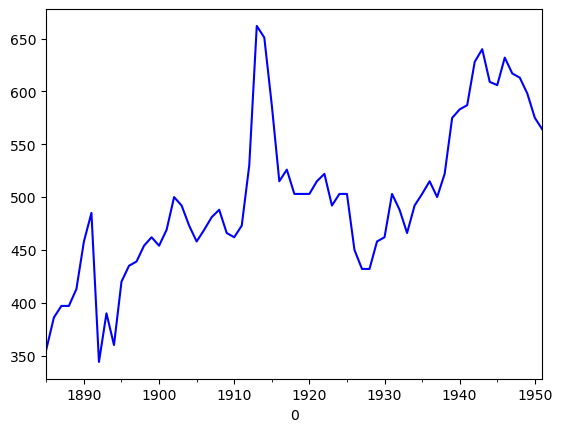

In [10]:
from matplotlib import pyplot

series.plot(color="Blue")
pyplot.show()

Some observations from the plot include:

There may be an increasing trend of sales over time.

There appears to be systematic seasonality to the sales for each year.

The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change).

There do not appear to be any obvious outliers.

The seasonality suggests that the series is almost certainly non-stationary.

## Seasonal Line Plots
We can confirm the assumption that the seasonality is a yearly cycle by eyeballing line plots of the dataset by year.

The example below takes the 7 full years of data as separate groups and creates one line plot for each. The line plots are aligned vertically to help spot any year-to-year pattern.

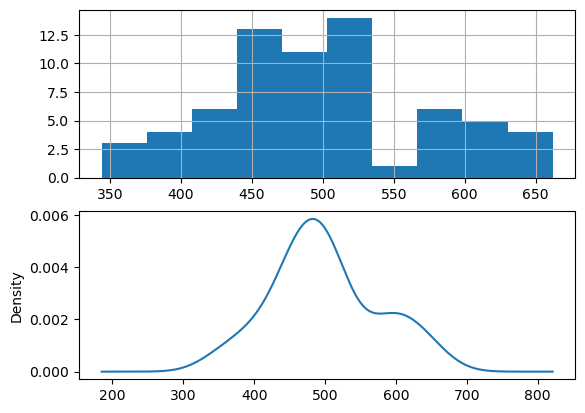

In [12]:
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

Some observations from the plots include:

- The distribution is not Gaussian, but is pretty close.
- The distribution has a long right tail and may suggest an exponential distribution or a double Gaussian.

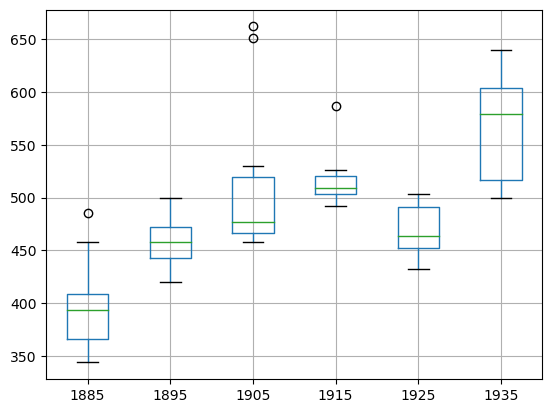

In [14]:

from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
# series = read_csv('dataset.csv')
groups = series['1885':'1944'].groupby(Grouper(freq='10AS'))
decades = DataFrame()
for name, group in groups:
	decades[name.year] = group.values
decades.boxplot()
pyplot.show()

Some observations from reviewing the plots include:

The median values for each year (red line) may show an increasing trend that may not be linear.

The spread, or middle 50% of the data (blue boxes), does show some variability.

There maybe outliers in some decades (crosses outside of the box and whiskers).

The second to last decade seems to have a lower average consumption, perhaps related to the first world war.

## ARIMA Models
In this section, we will develop Autoregressive Integrated Moving Average, or ARIMA, models for the problem. We will approach this in four steps:
1. Developing a manually configured ARIMA model.
2. Using a grid search of ARIMA to find an optimized model.
3. Analysis of forecast residual errors to evaluate any bias in the model. 
4. Explore improvements to the model using power transforms.

ADF Statistic: -6.820489
p-value: 0.000000
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


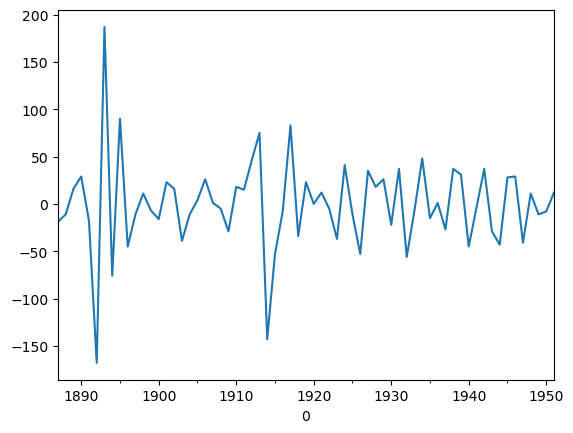

In [17]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller

# create a differe
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)

X = series.values
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
# save
stationary.to_csv('./water/water_stationary.csv', header=False)
# stationary.to_csv('./data/stationary.csv' class="crayon-t">, header=False</span>)
# plot differenced data
stationary.plot()
pyplot.show()

/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_13211/2583225576.py:5: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./water/water_stationary.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
/Users/parsanemati/Library/r-miniconda-arm64/envs/tensorflow/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


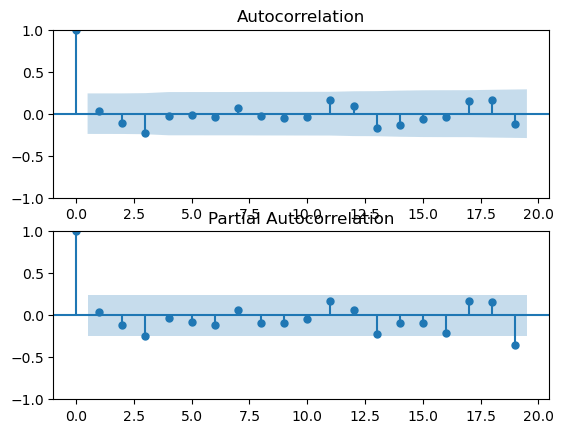

In [16]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = read_csv('./water/water_stationary.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

Below are some observations from the plots.

- The ACF shows a significant lag for 1 month.
- The PACF shows a significant lag for 1 month, with perhaps some significant lag at 12 and 13 months.
- Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA

A good starting point for the p and q values is also 1.



In [22]:
# evaluate manually configured ARIMA model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt


# load data
series = read_csv('./water/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(4,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

/var/folders/gy/ggsrtsh527x0w4bhcr8s0z140000gn/T/ipykernel_13211/2788582767.py:9: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('./water/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)


>Predicted=567.800, Expected=503.000
>Predicted=530.101, Expected=503.000
>Predicted=511.154, Expected=503.000
>Predicted=515.637, Expected=515.000
>Predicted=520.904, Expected=522.000
>Predicted=525.009, Expected=492.000
>Predicted=492.360, Expected=503.000
>Predicted=504.664, Expected=503.000
>Predicted=512.082, Expected=450.000
>Predicted=454.312, Expected=432.000
>Predicted=441.329, Expected=432.000
>Predicted=452.418, Expected=458.000
>Predicted=470.223, Expected=462.000
>Predicted=465.860, Expected=503.000
>Predicted=498.112, Expected=488.000
>Predicted=483.399, Expected=466.000
>Predicted=455.128, Expected=492.000
>Predicted=492.320, Expected=503.000
>Predicted=503.711, Expected=515.000
>Predicted=505.815, Expected=500.000
>Predicted=493.165, Expected=522.000
>Predicted=515.482, Expected=575.000
>Predicted=571.332, Expected=583.000
>Predicted=568.102, Expected=587.000
>Predicted=567.410, Expected=628.000
>Predicted=620.638, Expected=640.000
>Predicted=632.546, Expected=609.000
>

##  Grid Search ARIMA Hyperparameters
Many ARIMA configurations are unstable on this dataset, but there may be other hyperparam- eters that result in a well-performing model. In this section, we will search values of p, d, and q for combinations that do not result in error, and find the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values. Specifically, we will search all combinations of the following parameters:

- p: 0 to 12. 
- d: 0 to 3. 
- q: 0 to 12.

This is (13 * 4 * 13), or 676, runs of the test harness and will take some time to execute.



In [23]:
# grid search ARIMA parameters for a time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=77.401
ARIMA(0, 0, 1) RMSE=47.720
ARIMA(0, 0, 2) RMSE=36.498
ARIMA(0, 0, 3) RMSE=33.145
ARIMA(0, 0, 4) RMSE=30.237
ARIMA(0, 1, 0) RMSE=22.416
ARIMA(0, 1, 1) RMSE=22.379
ARIMA(0, 1, 2) RMSE=23.319
ARIMA(0, 1, 3) RMSE=25.401
ARIMA(0, 1, 4) RMSE=25.519
ARIMA(0, 2, 0) RMSE=29.972
ARIMA(0, 2, 1) RMSE=22.821
ARIMA(0, 2, 2) RMSE=22.758
ARIMA(0, 2, 3) RMSE=24.140
ARIMA(0, 2, 4) RMSE=29.412
ARIMA(1, 0, 0) RMSE=24.322
ARIMA(1, 0, 1) RMSE=24.394
ARIMA(1, 0, 2) RMSE=25.820
ARIMA(1, 0, 3) RMSE=25.718
ARIMA(1, 0, 4) RMSE=25.781
ARIMA(1, 1, 0) RMSE=22.388
ARIMA(1, 1, 1) RMSE=22.357
ARIMA(1, 1, 2) RMSE=23.924
ARIMA(1, 1, 3) RMSE=25.481
ARIMA(1, 1, 4) RMSE=28.164
ARIMA(1, 2, 0) RMSE=27.864
ARIMA(1, 2, 1) RMSE=22.769
ARIMA(1, 2, 2) RMSE=23.205
ARIMA(1, 2, 3) RMSE=23.330
ARIMA(1, 2, 4) RMSE=29.676
ARIMA(2, 0, 0) RMSE=24.493
ARIMA(2, 0, 1) RMSE=24.499
ARIMA(2, 0, 2) RMSE=25.770
ARIMA(2, 0, 3) RMSE=25.776
ARIMA(2, 0, 4) RMSE=26.171
ARIMA(2, 1, 0) RMSE=22.428
ARIMA(2, 1, 1) RMSE=24.652
A

## Review Residual Errors
A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean. We can check this by plotting the residuals with a histogram and density plots. The example below calculates the residual errors for predictions on the test set and creates these density plots.

               0
count  34.000000
mean    1.021180
std    22.741219
min   -52.104849
25%   -16.321730
50%     0.458993
75%    12.133594
max    51.281127


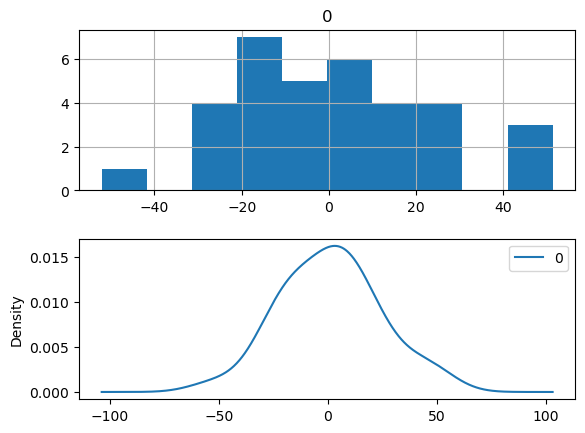

In [24]:
# summarize residual errors for an ARIMA model
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
# load data
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

In [ ]:
train, test

RMSE: 22.404
               0
count  34.000000
mean   -0.060444
std    22.741219
min   -53.186473
25%   -17.403354
50%    -0.622631
75%    11.051970
max    50.199503


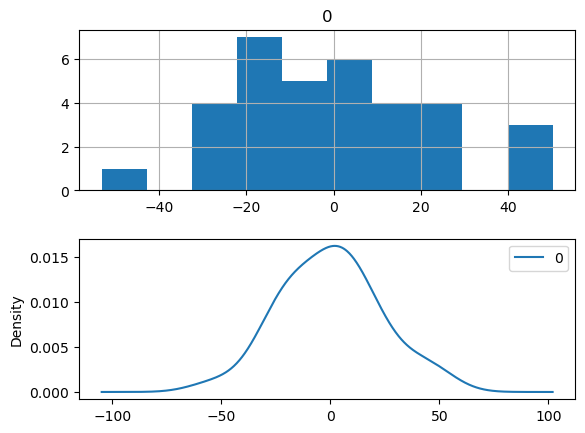

In [25]:
# summarize residual errors from bias corrected forecasts
from pandas import read_csv
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from matplotlib import pyplot
# load data
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 1.081624
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	yhat = bias + float(model_fit.forecast()[0])
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot residual errors
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

## Box-Cox Transformed Dataset
The Box-Cox transform is a method that is able to evaluate a suite of power transforms, including, but not limited to, log, square root, and reciprocal transforms of the data.

Some observations from these plots are follows:

- The large fluctuations have been removed from the line plot of the time series.
- The histogram shows a flatter or more uniform (well behaved) distribution of values.
- The Q-Q plot is reasonable, but still not a perfect fit for a Gaussian distribution.

Lambda: 0.237477


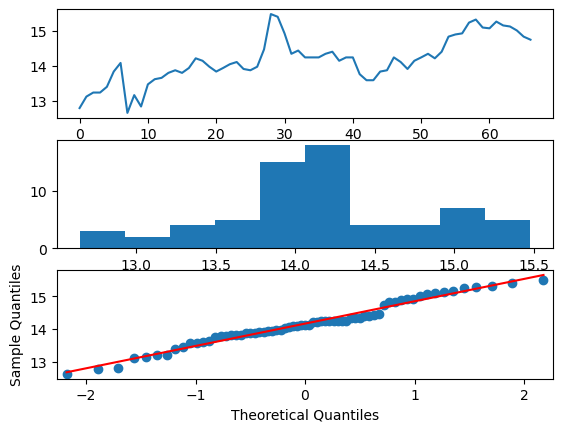

In [26]:
from pandas import read_csv
from pandas import DataFrame
from scipy.stats import boxcox
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
# series = read_csv('dataset.csv')
X = series.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram
pyplot.subplot(312)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca())
pyplot.show()

In [27]:
# evaluate ARIMA models with box-cox transformed time series
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox

# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

# load data
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# transform
	transformed, lam = boxcox(history)
	if lam < -5:
		transformed, lam = history, 1
	# predict
	model = ARIMA(transformed, order=(0,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	# invert transformed prediction
	yhat = boxcox_inverse(yhat, lam)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=545.753, Expected=503.000
>Predicted=508.484, Expected=503.000
>Predicted=510.428, Expected=503.000
>Predicted=505.054, Expected=515.000
>Predicted=515.992, Expected=522.000
>Predicted=520.499, Expected=492.000
>Predicted=494.745, Expected=503.000
>Predicted=507.992, Expected=503.000
>Predicted=502.792, Expected=450.000
>Predicted=457.441, Expected=432.000
>Predicted=442.816, Expected=432.000
>Predicted=436.527, Expected=458.000
>Predicted=458.969, Expected=462.000
>Predicted=459.131, Expected=503.000
>Predicted=500.648, Expected=488.000
>Predicted=483.006, Expected=466.000
>Predicted=470.167, Expected=492.000
>Predicted=493.450, Expected=503.000
>Predicted=498.889, Expected=515.000
>Predicted=512.855, Expected=500.000
>Predicted=499.108, Expected=522.000
>Predicted=519.632, Expected=575.000
>Predicted=563.520, Expected=583.000
>Predicted=574.064, Expected=587.000
>Predicted=583.871, Expected=628.000
>Predicted=622.326, Expected=640.000
>Predicted=637.160, Expected=609.000
>

## Model Validation
After models have been developed and a final model selected, it must be validated and finalized.

Validation is an optional part of the process, but one that provides a ‘last check’ to ensure we have not fooled or lied to ourselves.

This section includes the following steps:

- Finalize Model: Train and save the final model.
- Make Prediction: Load the finalized model and make a prediction.
- Validate Model: Load and validate the final model.

## Finalize Model
Finalizing the model involves fitting an ARIMA model on the entire dataset, in this case, on a transformed version of the entire dataset.

Once fit, the model can be saved to file for later use. Because a Box-Cox transform is also performed on the data, we need to know the chosen lambda so that any predictions from the model can be converted back to the original, untransformed scale.

In [31]:
# save finalized model
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
# prepare data
X = series.values
X = X.astype('float32')
# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit()
# bias constant, could be calculated from in-sample mean residual
bias = 1.081624

# save model
model_fit.save('./water/model.pkl')
numpy.save('./water/model_bias.npy', [bias])

- model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes the coefficients and all other internal data returned when fitting the model.
- model_lambda.npy This is the lambda value stored as a one-row, one-column NumPy array.

This is probably overkill and all that is really needed for operational use are the AR and MA coefficients from the model, the d parameter for the number of differences, perhaps the lag observations and model residuals, and the lambda value for the transform.

## Make Prediction
A natural case may be to load the model and make a single forecast.

This is relatively straightforward and involves restoring the saved model and the lambda and calling the forecast() method.

In [33]:
# load finalized model and make a prediction
from statsmodels.tsa.arima.model import ARIMAResults
import numpy
model_fit = ARIMAResults.load('./water/model.pkl')
bias = numpy.load('./water/model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 566.981


## Validate Model
We can load the model and use it in a pretend operational manner.

In the test harness section, we saved the final 12 months of the original dataset in a separate file to validate the final model.

We can load this validation.csv file now and use it see how well our model really is on “unseen” data.

There are two ways we might proceed:

Load the model and use it to forecast the next 12 months. The forecast beyond the first one or two months will quickly start to degrade in skill.
Load the model and use it in a rolling-forecast manner, updating the transform and model for each time step. This is the preferred method as it is how one would use this model in practice, as it would achieve the best performance.

>Predicted=566.981, Expected=549.000
>Predicted=550.466, Expected=538.000
>Predicted=540.011, Expected=568.000
>Predicted=571.593, Expected=575.000
>Predicted=573.292, Expected=579.000
>Predicted=579.562, Expected=587.000
>Predicted=588.064, Expected=602.000
>Predicted=603.025, Expected=594.000
>Predicted=593.177, Expected=587.000
>Predicted=588.556, Expected=587.000
>Predicted=588.796, Expected=625.000
>Predicted=627.947, Expected=613.000
RMSE: 16.360


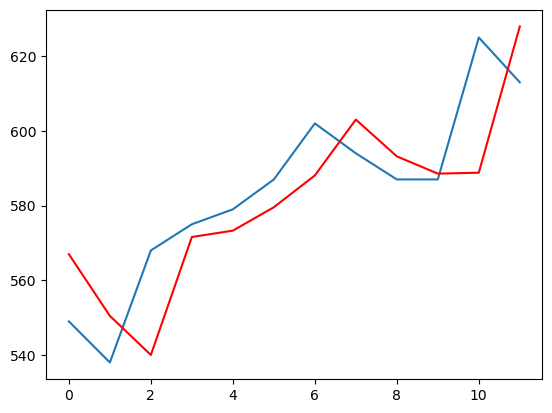

In [34]:

# load and evaluate the finalized model on the validation dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy
# load and prepare datasets
dataset = read_csv('./water/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
validation = read_csv('./water/validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('./water/model.pkl')
bias = numpy.load('./water/model_bias.npy')
# make first prediction
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	yhat = bias + float(model_fit.forecast()[0])
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

This section lists some ideas.

- Statistical Significance Tests. Use a statistical test to check if the difference in results between different models is statistically significant. The Student t-test would be a good place to start.
- Grid Search with Data Transforms. Repeat the grid search in the ARIMA hyperparameters with the Box-Cox transform and see if a different and better set of parameters can be achieved.
- Inspect Residuals. Investigate the residual forecast errors on the final model with Box-Cox transforms to see if there is a further bias and/or autocorrelation that can be addressed.
- Lean Model Saving. Simplify model saving to only store the required coefficients rather than the entire ARIMAResults object.
- Manually Handle Trend. Model the trend directly with a linear or nonlinear model and explicitly remove it from the series. This may result in better performance if the trend is nonlinear and can be modeled better than the linear case.
- Confidence Interval. Display the confidence intervals for the predictions on the validation dataset.
- Data Selection. Consider modeling the problem without the first two years of data and see if this has an impact on forecast skill.